## Ocean pCO2 diagnostics for HOPE ensemble member 001

## CESM emissions-driven run tutorial

### By Kristen Krumhardt

# ---------------------------

### Import statements (using NPL 2023a environment)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools 
import pandas as pd
import utils_ocean as utils

### Grab years 1998 to 2015 of pCO2 from the model (includes historical and future forcing)

#### define case name and path

In [2]:
case1 = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001'
path1 = '/glade/campaign/cesm/community/bgcwg/HOPE/' + case1 + '/ocn/proc/tseries/month_1'

case2 = 'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001'
path2 = '/glade/campaign/cesm/community/bgcwg/HOPE/' + case2 + '/ocn/proc/tseries/month_1'

#### define variable name and the variables to keep

In [3]:
variables = ['pCO2SURF'] 

keep_vars = ['z_t','z_t_150m','time_bound','TAREA',
             'REGION_MASK','dz','KMT','TLONG','TLAT','time','time_bounds'] + variables

#### Read in the historical data

In [4]:
files = []

for var in variables:

    files.extend(sorted(glob(f'{path1}/{case1}.pop.h.{var}.185001-201412.nc')))

ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, combine='nested')

## fix time bounds
ds['time'] = ds.time_bound.compute().mean(dim="d2")

#### Trim the historial data for 1998 to 2014

In [5]:
ds = ds.isel(time=slice(1776,1980))

#### Now grab year 2015 from the SSP2 scenario run

In [6]:
files = []

for var in variables:

    files.extend(sorted(glob(f'{path2}/{case2}.pop.h.{var}.201501-210012.nc')))

ds_tmp = xr.open_mfdataset(files,decode_times=True,decode_coords=False, combine='nested')

## fix time bounds
ds_tmp['time'] = ds_tmp.time_bound.compute().mean(dim="d2")

#### We just need 2015 so just get that year

In [7]:
ds_tmp = ds_tmp.isel(time=slice(0,12))

#### Concat the datasets together so it's one dataset that covers 1998 to 2015

In [8]:
ds = xr.concat((ds,ds_tmp),dim='time')

#### Drop extra variables

In [9]:
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [10]:
ds

<xarray.Dataset>
Dimensions:      (z_t: 60, z_t_150m: 15, time: 216, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m     (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * time         (time) object 1998-01-16 12:00:00 ... 2015-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    dz           (time, z_t) float32 dask.array<chunksize=(204, 60), meta=np.ndarray>
    TLONG        (time, nlat, nlon) float64 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
    TLAT         (time, nlat, nlon) float64 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
    KMT          (time, nlat, nlon) float64 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
    REGION_MASK  (time, nlat, nlon) float64 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
    TAREA        (time, nlat, nlon) float64 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
    time_bound   (time, d2) object dask.array<chunksize=(204, 2), meta=np.ndarray>
    pCO2SURF     (time, nlat, nlon) float32 dask.array<chunksize=(204, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-06-21 at 01:31:33.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Make a climatology over the 1998 to 2015 period to match the observation dataset

In [11]:
ds = ds.groupby('time.month').mean('time')

### Get the [Landschützer et al. (2020)](https://essd.copernicus.org/articles/12/2537/2020/essd-12-2537-2020.pdf) pCO2 climatology observation-based product that covers 1998 to 2015

In [12]:
file = '/glade/work/kristenk/pCO2_obs_product/MPI-ULB-SOM_FFN_clim.nc'

ds_obs = xr.open_dataset(file)

### turn the -999s in the dataset to nans
ds_obs['pco2'] = ds_obs['pco2'].where(ds_obs['pco2'] != -999)

### Make maps for each month, comparing CESM to Landschützer

#### Use pop tools to get ocean grid info

In [13]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG

In [14]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#### Make ocean surface pCO2 maps for each month (this step takes a couple of min)

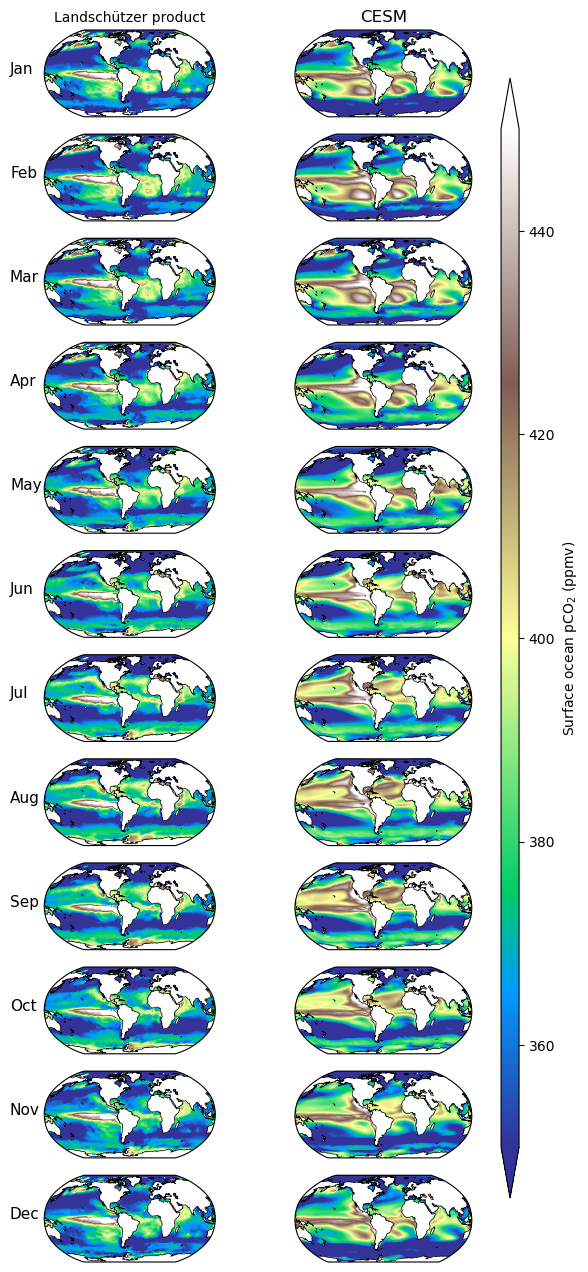

In [15]:
fig = plt.figure(figsize=(6,16))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    if row == 1:
        ax.set_title('Landschützer product', fontsize=10)
    pc=ax.pcolormesh(ds_obs.lon, ds_obs.lat, ds_obs.pco2.isel(time=ts), 
                     cmap='terrain',vmin=350,vmax=450,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    ax.text(-0.2,0.5, months[ts], fontsize=11, transform=ax.transAxes)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    if row == 1:
        ax.set_title('CESM', fontsize=12)
    tmp = ds.pCO2SURF.isel(month=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='terrain',vmin=350,vmax=450,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='Surface ocean pCO$_2$ (ppmv)');
